In [1]:
!pip install d2l==0.15.1
!pip install -U mxnet-cu101==1.7.0


     |████████████████████████████████| 61kB 3.3MB/s 
     |███████████████████████████████▌| 834.1MB 1.2MB/s eta 0:00:10tcmalloc: large alloc 1147494400 bytes == 0x656b2000 @  0x7f7a64ecf615 0x591e47 0x4cc179 0x4cc2db 0x50a1cc 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50cc96 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x58e683 0x50c127 0x5095c8 0x50a2fd 0x50beb4 0x507be4 0x509900 0x50a2fd 0x50beb4 0x5095c8 0x50a2fd
     |████████████████████████████████| 846.0MB 22kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [2]:
from d2l import mxnet as d2l
from mxnet import gluon, init, np, npx
from mxnet.gluon import nn, rnn
npx.set_np()

batch_size = 64
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [3]:
class BiRNN(nn.Block):
    def __init__(self, vocab_size, embed_size, num_hiddens,
                 num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = rnn.LSTM(num_hiddens, num_layers=num_layers,
                                bidirectional=True, input_size=embed_size)
        self.decoder = nn.Dense(2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # rnn.LSTM, it only returns the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        outputs = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = np.concatenate((outputs[0], outputs[-1]), axis=1)
        outs = self.decoder(encoding)
        return outs

In [4]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)
net.initialize(init.Xavier(), ctx=devices)

In [9]:
glove_embedding = d2l.TokenEmbedding('glove.6b.300d')

AssertionError: ignored

In [6]:
embeds = glove_embedding[vocab.idx_to_token]
embeds.shape

(49346, 100)

In [7]:
net.embedding.weight.set_data(embeds)
net.embedding.collect_params().setattr('grad_req', 'null')

loss 0.300, train acc 0.872, test acc 0.853
759.3 examples/sec on [gpu(0)]


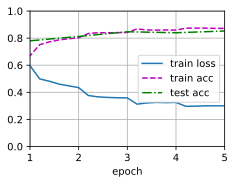

In [8]:
lr, num_epochs = 0.01, 5
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr})
loss = gluon.loss.SoftmaxCrossEntropyLoss()
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [ ]:
#@save
def predict_sentiment(net, vocab, sentence):
    sentence = np.array(vocab[sentence.split()], ctx=d2l.try_gpu())
    label = np.argmax(net(sentence.reshape(1, -1)), axis=1)
    return 'positive' if label == 1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

## Summary

* Text classification transforms a sequence of text of indefinite length into a category of text. This is a downstream application of word embedding.
* We can apply pre-trained word vectors and recurrent neural networks to classify the emotions in a text.


## Exercises

1. Increase the number of epochs. What accuracy rate can you achieve on the training and testing datasets? What about trying to re-tune other hyperparameters?
1. Will using larger pre-trained word vectors, such as 300-dimensional GloVe word vectors, improve classification accuracy?
1. Can we improve the classification accuracy by using the spaCy word tokenization tool? You need to install spaCy: `pip install spacy` and install the English package: `python -m spacy download en`. In the code, first import spacy: `import spacy`. Then, load the spacy English package: `spacy_en = spacy.load('en')`. Finally, define the function `def tokenizer(text): return [tok.text for tok in spacy_en.tokenizer(text)]` and replace the original `tokenizer` function. It should be noted that GloVe's word vector uses "-" to connect each word when storing noun phrases. For example, the phrase "new york" is represented as "new-york" in GloVe. After using spaCy tokenization, "new york" may be stored as "new york".


[Discussions](https://discuss.d2l.ai/t/392)
